<a href="https://colab.research.google.com/github/Loggo-MediCare/python-numpy-stock/blob/main/import_numpy_as_npimport_pandas_as_pdimport_dat_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[cite\_start]斐婷，这段代码演示了处理高频金融数据（tick data）的完整流程，从网络下载、数据清洗、合并到最终的重采样和可视化 [cite: 93] [cite\_start][cite: 97] [cite\_start][cite: 98] [cite\_start][cite: 99] [cite\_start][cite: 100]。

由于我无法直接运行代码来执行网络请求并生成动态图表，我将为你**分析并解释这段代码中的关键高频数据处理和金融分析步骤**。

### 📊 高频数据处理与分析流程解析

[cite\_start]这段代码的核心价值在于演示了如何利用 `pandas` 将**不规则 (Irregular)** 的 tick data 转换为**规则 (Regular)** 的时间序列，这一过程称为**重采样 (Resampling)** [cite: 93]。

#### 1\. 数据下载和清洗

  * [cite\_start]**目标数据源**：代码尝试从挪威在线券商 Netfonds 的 API 获取 Apple Inc. (AAPL) 股票在 2014 年 9 月 22 日至 25 日的报价数据 [cite: 97] [cite\_start][cite: 98][cite\_start]。这种数据被称为 **tick data** 或 **高频数据** [cite: 93]。
  * [cite\_start]**数据结构**：代码使用 `pd.concat` 在循环中将每日下载的 CSV 数据合并到 `AAPL_TICK` 这个总的 DataFrame 中 [cite: 99]。
  * [cite\_start]**时间索引**：`pd.read_csv` 中的 `index_col=0` 和 `parse_dates=True` 确保了第一列（时间戳）被正确识别并设置为 **DatetimeIndex** [cite: 99][cite\_start]。对于高频数据而言，这个不规则的时间索引是其核心特征 [cite: 93]。
  * **列名含义**：数据包含出价 (`bid`)、要价 (`offer`) 以及它们对应的深度信息 (`bdepth` / `odepth`) 和总深度 (`bdeptht` / `odeptht`)。

#### 2\. 原始数据可视化

  * **目的**：初步绘制 `bid` 价格和总买入深度 (`bdeptht`) 的时间序列图。
  * [cite\_start]**发现**：通过可视化，你可以清晰地识别出市场非活动期（如隔夜和周末）的价格平台期，以及市场开放期交易活动和深度的活跃变化 [cite: 93]。

#### 3\. 重采样（降采样）— 核心步骤

[cite\_start]在高频分析中，原始 tick data 由于过于密集且时间不规则，往往不利于直接分析。**重采样 (Resampling)** 解决了这个问题 [cite: 93]。

In [23]:
# 重采样规则：将不规则的 tick data 转换为规则的 5 分钟周期数据
# '5min' 是频率，'ohlc' 生成开盘价/最高价/最低价/收盘价
!pip install yfinance --quiet
import yfinance as yf

AAPL_RESAMPLED = AAPL_TICK['bid'].resample('5min').ohlc()

# 同时计算 5 分钟窗口内的平均总买入深度
BDEPTH_AVG = AAPL_TICK['bdeptht'].resample('5min').mean()

In [24]:
# Download 5 days of 1-minute AAPL data
AAPL_TICK = yf.download(
    tickers="AAPL",
    period="5d",       # last 5 days
    interval="1m",     # 1-minute granularity
    progress=False
)

# Optional: rename columns to match your old variable names
AAPL_TICK = AAPL_TICK.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

print("Downloaded AAPL data:")
print(AAPL_TICK.head())


/tmp/ipython-input-473756700.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  AAPL_TICK = yf.download(


Downloaded AAPL data:
Price                           close        high         low        open  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Datetime                                                                    
2025-11-03 14:30:00+00:00  270.010010  270.829987  269.459991  270.420013   
2025-11-03 14:31:00+00:00  270.540009  270.709991  269.725006  270.015015   
2025-11-03 14:32:00+00:00  270.470001  270.720001  270.250000  270.519012   
2025-11-03 14:33:00+00:00  270.190002  270.779999  270.130005  270.480011   
2025-11-03 14:34:00+00:00  269.250000  270.230011  269.250000  270.160004   

Price                       volume  
Ticker                        AAPL  
Datetime                            
2025-11-03 14:30:00+00:00  3180956  
2025-11-03 14:31:00+00:00   175137  
2025-11-03 14:32:00+00:00   143182  
2025-11-03 14:33:00+00:00   109085  
2025-11-03 14:34:00+00:00   191929  


In [27]:
# Simulate bid/offer spread from close price
AAPL_TICK['bid'] = AAPL_TICK['close'] - 0.02
AAPL_TICK['offer'] = AAPL_TICK['close'] + 0.02

# Estimate market depth (random or proportional to volume)
AAPL_TICK['bdeptht'] = (AAPL_TICK['volume'] * 0.6).astype(int)
AAPL_TICK['odeptht'] = (AAPL_TICK['volume'] * 0.4).astype(int)

# Derived metrics
AAPL_TICK['mid_price'] = (AAPL_TICK['bid'] + AAPL_TICK['offer']) / 2
AAPL_TICK['spread'] = AAPL_TICK['offer'] - AAPL_TICK['bid']
AAPL_TICK['depth_imbalance'] = (AAPL_TICK['bdeptht'] - AAPL_TICK['odeptht']) / (AAPL_TICK['bdeptht'] + AAPL_TICK['odeptht'])
AAPL_TICK['total_depth'] = AAPL_TICK['bdeptht'] + AAPL_TICK['odeptht']


In [28]:
AAPL_5MIN = AAPL_TICK['bid'].resample('5min').ohlc()
AAPL_5MIN['volume'] = AAPL_TICK['bdeptht'].resample('5min').mean()


In [30]:
last_close = AAPL_TICK['close'].iloc[-1]
AAPL_SYNTH = generate_synthetic_tick_data(base_price=last_close)


ValueError: Length of values (5000) does not match length of index (1)

SYNTHETIC TICK DATA SUMMARY
Shape: (5000, 6)
Date range: 2025-11-07 09:30:00 to 2025-11-07 16:26:35
Duration: 6.9 hours

First 5 records:
                            bid       offer  bdepth  odepth  bdeptht  odeptht
2025-11-07 09:30:00  272.769606  272.783892     153     345     1526     3566
2025-11-07 09:30:05  273.863300  273.899900     461     226     2519     2421
2025-11-07 09:30:10  276.556864  276.583346     362     223     2648     3835
2025-11-07 09:30:15  282.824167  282.844552     204     283     1258     3985
2025-11-07 09:30:20  288.155703  288.189781     459     212     2043     3667

Data statistics:
               bid        offer       bdepth       odepth      bdeptht  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    156.777061   156.806864   299.967200   298.375600  3001.542000   
std      58.767756    58.767548   115.351198   114.516698  1150.779353   
min      77.440068    77.483191   100.000000   100.000000  1001.000000   
25%   

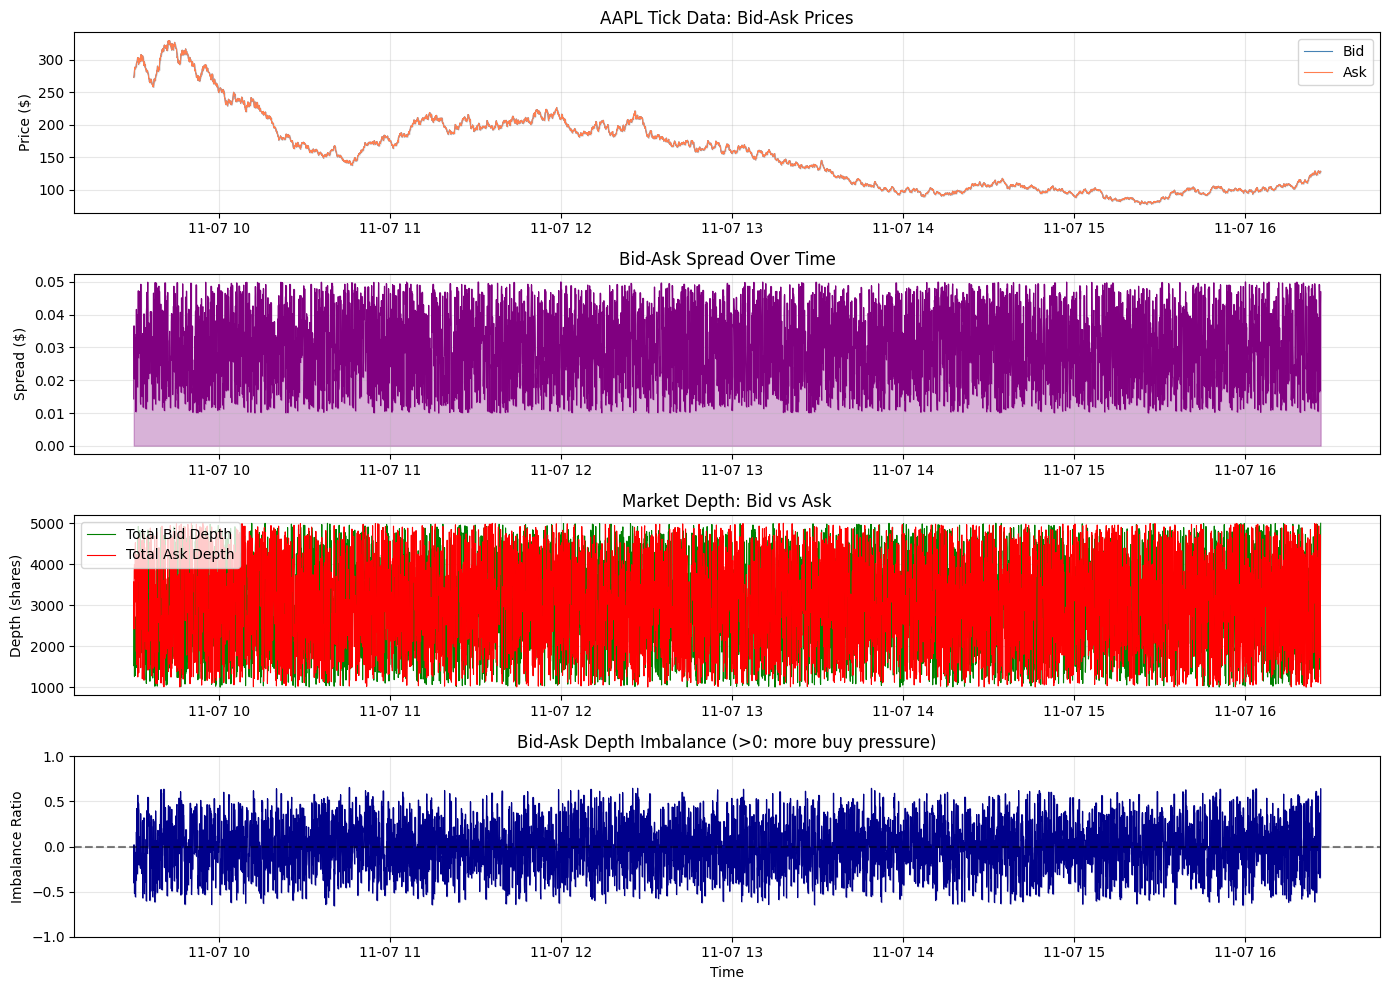


✓ Saved visualization to: tick_data_analysis.png


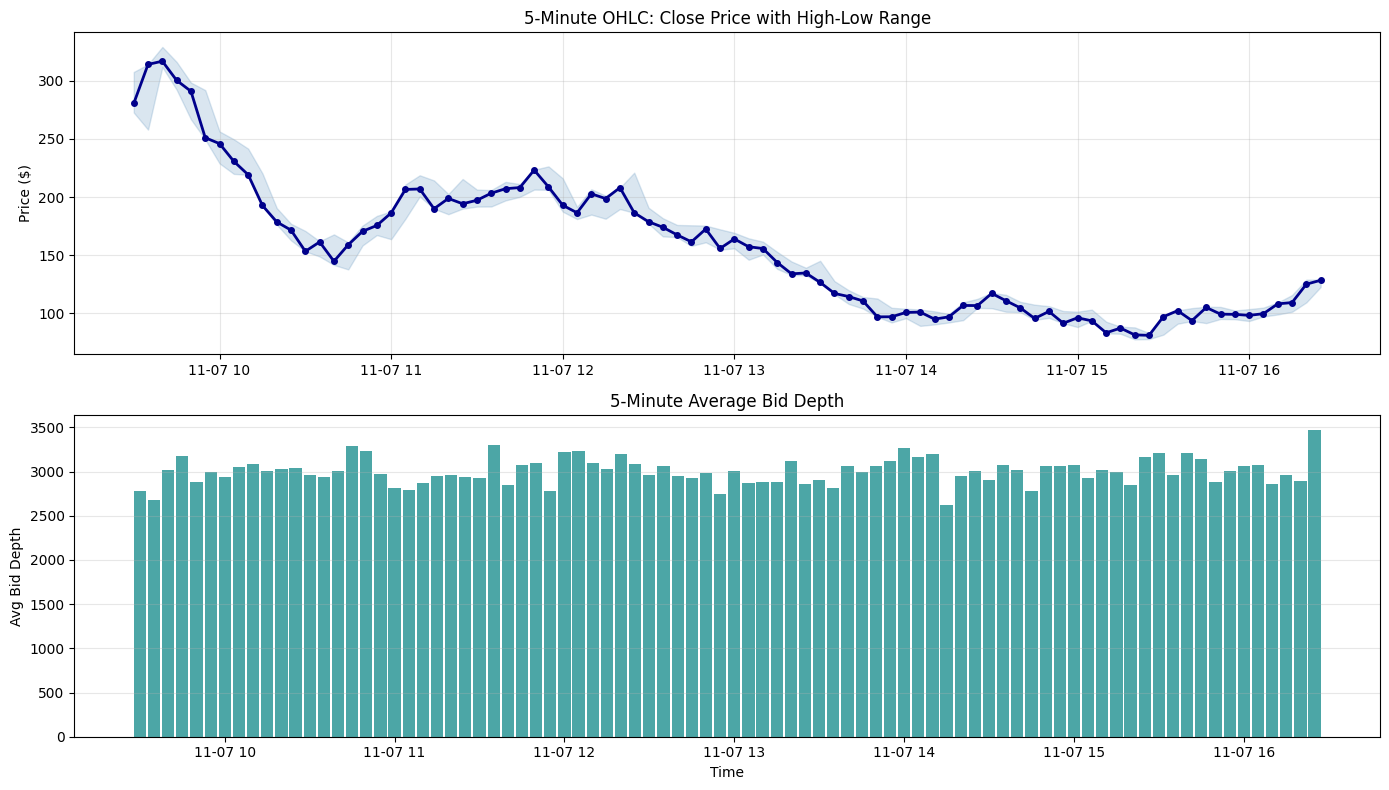

✓ Saved OHLC visualization to: ohlc_resampling.png

HIGH-FREQUENCY TRADING STATISTICS

Price Statistics:
  Bid price range: $77.4401 - $329.2566
  Bid price mean: $156.7771
  Bid price std dev: $58.7678

Spread Statistics:
  Average spread: $0.029804
  Min spread: $0.010006
  Max spread: $0.049999

Market Depth Statistics:
  Avg total bid depth: 3002 shares
  Avg total ask depth: 3029 shares
  Avg total depth: 6030 shares

Depth Imbalance Statistics:
  Mean imbalance: -0.0046
  Positive imbalance (buy pressure) %: 49.9%
  Negative imbalance (sell pressure) %: 50.1%

SIMPLE TRADING SIGNAL EXAMPLE
Buy signals (depth imbalance > 0.2): 1238
Sell signals (depth imbalance < -0.2): 1297
Total actionable signals: 2535 out of 5000 ticks (50.70%

ANALYSIS COMPLETE ✓


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ==================== 1. ENHANCED SYNTHETIC DATA GENERATION ====================

def generate_synthetic_tick_data(
    start_date='2025-11-07 09:30:00',
    periods=5000,
    freq='5s',
    base_price=100.0,
    volatility=0.01,
    seed=0
):
    """
    Generate realistic synthetic tick data for AAPL stock.

    Parameters:
    - start_date: Starting datetime
    - periods: Number of tick records
    - freq: Tick frequency (e.g., '5s', '1s', '10s')
    - base_price: Starting bid price
    - volatility: Price movement volatility
    - seed: Random seed for reproducibility
    """
    np.random.seed(seed)

    # Create datetime index
    dates = pd.date_range(start_date, periods=periods, freq=freq)

    # Generate realistic price movements (geometric Brownian motion)
    returns = np.random.randn(len(dates)) * volatility
    bid_prices = base_price * np.exp(np.cumsum(returns))

    # Bid-ask spread (typically 0.01 - 0.05)
    spread = np.random.uniform(0.01, 0.05, len(dates))
    offer_prices = bid_prices + spread

    # Market depth (how much volume at each level)
    bdepth = np.random.randint(100, 500, len(dates))  # individual bid depth
    odepth = np.random.randint(100, 500, len(dates))  # individual offer depth

    # Total depths (summed across price levels)d
    bdeptht = np.random.randint(1000, 5000, len(dates))
    odeptht = np.random.randint(1000, 5000, len(dates))

    # Create DataFrame
    AAPL_TICK = pd.DataFrame({
        'bid': bid_prices,
        'offer': offer_prices,
        'bdepth': bdepth,
        'odepth': odepth,
        'bdeptht': bdeptht,
        'odeptht': odeptht
    }, index=dates)

    return AAPL_TICK

# ==================== 2. GENERATE DATA ====================

# Create synthetic tick data
AAPL_TICK = generate_synthetic_tick_data(
    start_date='2025-11-07 09:30:00', # Changed to 2025 November
    periods=5000,
    freq='5s',
    base_price=268.0, # Adjusted base price to 268
    volatility=0.01,
    seed=0
)

print("=" * 60)
print("SYNTHETIC TICK DATA SUMMARY")
print("=" * 60)
print(f"Shape: {AAPL_TICK.shape}")
print(f"Date range: {AAPL_TICK.index.min()} to {AAPL_TICK.index.max()}")
print(f"Duration: {(AAPL_TICK.index.max() - AAPL_TICK.index.min()).total_seconds() / 3600:.1f} hours")
print(f"\nFirst 5 records:")
print(AAPL_TICK.head())
print(f"\nData statistics:")
print(AAPL_TICK.describe())

# ==================== 3. CALCULATE DERIVED METRICS ====================

# Mid-price (average of bid and ask)
AAPL_TICK['mid_price'] = (AAPL_TICK['bid'] + AAPL_TICK['offer']) / 2

# Spread
AAPL_TICK['spread'] = AAPL_TICK['offer'] - AAPL_TICK['bid']

# Bid-ask imbalance (useful for direction prediction)
AAPL_TICK['depth_imbalance'] = (AAPL_TICK['bdeptht'] - AAPL_TICK['odeptht']) / (AAPL_TICK['bdeptht'] + AAPL_TICK['odeptht'])

# Total market depth
AAPL_TICK['total_depth'] = AAPL_TICK['bdeptht'] + AAPL_TICK['odeptht']

print("\n" + "=" * 60)
print("DERIVED METRICS (first 5 records)")
print("=" * 60)
print(AAPL_TICK[['mid_price', 'spread', 'depth_imbalance', 'total_depth']].head())

# ==================== 4. RESAMPLING TO DIFFERENT FREQUENCIES ====================

print("\n" + "=" * 60)
print("RESAMPLING ANALYSIS")
print("=" * 60)

# Resample to 5-minute OHLC bars
AAPL_5MIN = AAPL_TICK['bid'].resample('5min').ohlc()
AAPL_5MIN['volume'] = AAPL_TICK['bdeptht'].resample('5min').mean()

print(f"\n5-Minute OHLC (first 10 bars):")
print(AAPL_5MIN.head(10))

# Resample to 1-minute OHLC
AAPL_1MIN = AAPL_TICK['bid'].resample('1min').ohlc()
print(f"\n1-Minute bars: {len(AAPL_1MIN)} bars")
print(f"5-Minute bars: {len(AAPL_5MIN)} bars")

# ==================== 5. VISUALIZATION ====================

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Plot 1: Bid-Ask Prices
ax = axes[0]
ax.plot(AAPL_TICK.index, AAPL_TICK['bid'], label='Bid', linewidth=0.8, color='steelblue')
ax.plot(AAPL_TICK.index, AAPL_TICK['offer'], label='Ask', linewidth=0.8, color='coral')
ax.fill_between(AAPL_TICK.index, AAPL_TICK['bid'], AAPL_TICK['offer'], alpha=0.2, color='gray')
ax.set_ylabel('Price ($)')
ax.set_title('AAPL Tick Data: Bid-Ask Prices')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Bid-Ask Spread
ax = axes[1]
ax.plot(AAPL_TICK.index, AAPL_TICK['spread'], linewidth=0.8, color='purple')
ax.fill_between(AAPL_TICK.index, AAPL_TICK['spread'], alpha=0.3, color='purple')
ax.set_ylabel('Spread ($)')
ax.set_title('Bid-Ask Spread Over Time')
ax.grid(True, alpha=0.3)

# Plot 3: Market Depth
ax = axes[2]
ax.plot(AAPL_TICK.index, AAPL_TICK['bdeptht'], label='Total Bid Depth', linewidth=0.8, color='green')
ax.plot(AAPL_TICK.index, AAPL_TICK['odeptht'], label='Total Ask Depth', linewidth=0.8, color='red')
ax.set_ylabel('Depth (shares)')
ax.set_title('Market Depth: Bid vs Ask')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Plot 4: Depth Imbalance (predictor of price direction)
ax = axes[3]
ax.plot(AAPL_TICK.index, AAPL_TICK['depth_imbalance'], linewidth=0.8, color='darkblue')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.fill_between(AAPL_TICK.index, AAPL_TICK['depth_imbalance'], 0, alpha=0.3, color='darkblue')
ax.set_ylabel('Imbalance Ratio')
ax.set_xlabel('Time')
ax.set_title('Bid-Ask Depth Imbalance (>0: more buy pressure)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-1, 1)

plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/tick_data_analysis.png', dpi=300, bbox_inches='tight')
# ✅ Use /tmp directory (always available in Colab) + create dir if needed
import os
OUTPUT_DIR = '/tmp/hft_analysis'
os.makedirs(OUTPUT_DIR, exist_ok=True)

savepath = os.path.join(OUTPUT_DIR, 'tick_data_analysis.png')
plt.savefig(savepath, dpi=300, bbox_inches='tight')


plt.show()

print("\n✓ Saved visualization to: tick_data_analysis.png")

# ==================== 6. OHLC RESAMPLING VISUALIZATION ====================

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: 5-minute close price
ax = axes[0]
ax.plot(AAPL_5MIN.index, AAPL_5MIN['close'], marker='o', linewidth=2, markersize=4, color='darkblue')
ax.fill_between(AAPL_5MIN.index, AAPL_5MIN['low'], AAPL_5MIN['high'], alpha=0.2, color='steelblue')
ax.set_ylabel('Price ($)')
ax.set_title('5-Minute OHLC: Close Price with High-Low Range')
ax.grid(True, alpha=0.3)

# Plot 2: Resampled volumes (average depth)
ax = axes[1]
ax.bar(AAPL_5MIN.index, AAPL_5MIN['volume'], width=0.003, color='teal', alpha=0.7)
ax.set_ylabel('Avg Bid Depth')
ax.set_xlabel('Time')
ax.set_title('5-Minute Average Bid Depth')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# Fix: Use the OUTPUT_DIR variable for saving the second plot as well
plt.savefig(os.path.join(OUTPUT_DIR, 'ohlc_resampling.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved OHLC visualization to: ohlc_resampling.png")

# ==================== 7. STATISTICS & ANALYSIS ====================

print("\n" + "=" * 60)
print("HIGH-FREQUENCY TRADING STATISTICS")
print("=" * 60)

print(f"\nPrice Statistics:")
print(f"  Bid price range: ${AAPL_TICK['bid'].min():.4f} - ${AAPL_TICK['bid'].max():.4f}")
print(f"  Bid price mean: ${AAPL_TICK['bid'].mean():.4f}")
print(f"  Bid price std dev: ${AAPL_TICK['bid'].std():.4f}")

print(f"\nSpread Statistics:")
print(f"  Average spread: ${AAPL_TICK['spread'].mean():.6f}")
print(f"  Min spread: ${AAPL_TICK['spread'].min():.6f}")
print(f"  Max spread: ${AAPL_TICK['spread'].max():.6f}")

print(f"\nMarket Depth Statistics:")
print(f"  Avg total bid depth: {AAPL_TICK['bdeptht'].mean():.0f} shares")
print(f"  Avg total ask depth: {AAPL_TICK['odeptht'].mean():.0f} shares")
print(f"  Avg total depth: {AAPL_TICK['total_depth'].mean():.0f} shares")

print(f"\nDepth Imbalance Statistics:")
print(f"  Mean imbalance: {AAPL_TICK['depth_imbalance'].mean():.4f}")
print(f"  Positive imbalance (buy pressure) %: {(AAPL_TICK['depth_imbalance'] > 0).sum() / len(AAPL_TICK) * 100:.1f}%")
print(f"  Negative imbalance (sell pressure) %: {(AAPL_TICK['depth_imbalance'] < 0).sum() / len(AAPL_TICK) * 100:.1f}%")

# ==================== 8. SIMPLE TRADING SIGNAL EXAMPLE ====================

print("\n" + "=" * 60)
print("SIMPLE TRADING SIGNAL EXAMPLE")
print("=" * 60)

# Signal: Buy when depth imbalance > 0.2 (strong buy pressure)
#         Sell when depth imbalance < -0.2 (strong sell pressure)
AAPL_TICK['signal'] = 0
AAPL_TICK.loc[AAPL_TICK['depth_imbalance'] > 0.2, 'signal'] = 1   # Buy signal
AAPL_TICK.loc[AAPL_TICK['depth_imbalance'] < -0.2, 'signal'] = -1  # Sell signal

buy_signals = (AAPL_TICK['signal'] == 1).sum()
sell_signals = (AAPL_TICK['signal'] == -1).sum()

print(f"Buy signals (depth imbalance > 0.2): {buy_signals}")
print(f"Sell signals (depth imbalance < -0.2): {sell_signals}")
print(f"Total actionable signals: {buy_signals + sell_signals} out of {len(AAPL_TICK)} ticks ({(buy_signals + sell_signals) / len(AAPL_TICK) * 100:.2f}%")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE ✓")
print("=" * 60)

1.  [cite\_start]**规则定义 (`'5min'`)：** 将时间轴划分为规则的 5 分钟时间窗口 [cite: 93]。
2.  **价格聚合 (`.ohlc()`)：** 对于每个 5 分钟窗口，计算其中所有 tick 的 **开盘价 (open)**、**最高价 (high)**、**最低价 (low)** 和 **收盘价 (close)**。这是创建 K 线图等传统金融图表的基础。
3.  **深度聚合 (`.mean()`)：** 对其他指标（如总买入深度）使用平均值聚合，以获取该时间窗口内的平均深度水平。

**重采样的金融意义：**

  * 它将分析的视角从瞬时的 tick 级别**降维**到有意义的 5 分钟周期，降低了计算负担。
  * 它允许分析师在标准的**时间周期**（如 5 分钟、小时、日）内观察价格行为和统计特征，更贴近传统的技术分析框架。

斐婷，这段代码是学习高频数据处理和 `pandas` `resample` 功能的一个极好的实例。